In [69]:
import math
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict, Counter
from glob import glob

In [70]:
with open("data/TEXTEN1.txt", "r") as f:
    text_en = f.read()

with open("data/TEXTCZ1.txt", "r", encoding="iso8859_2") as f:
    text_cz = f.read()

In [71]:
def perturb(text, p):
    """
    Randomly replace letters with probability `p`,
    while keeping word barriers intact.
    """
    alphabet = list(set(text_en) - set(["\n"]))
    
    return "".join([c
                    if (random.random() > p or c == "\n")
                    else random.choice(alphabet)
                    for c in text])


def split_text(text):
    words = text.split("\n")
    bigrams = list(zip(words, words[1:])) + [(words[-1], "<END>")]
    
    return words, bigrams

In [72]:
X = np.arange(0, 1.01, step=0.2)
texts = [perturb(text_en, e) for e in X]

In [73]:
a, b = split_text(texts[0])
assert len(a) == len(b)  # Just to make sure we padded the bigrams correctly

In [74]:
def text_entropy(text, plot=False):
    words, bigrams = split_text(text)
    
    c_1 = Counter(words)
    c_2 = Counter(bigrams)
    
    total_c1 = sum(c_1.values())
    total_c2 = sum(c_2.values())
    
    assert total_c1 == total_c2
    
    p_1 = {word: float(count) / total_c1 for word, count in c_1.items()}
    p_2 = {word: float(count) / total_c2 for word, count in c_2.items()}
    
    if plot:
        print(sorted(c_1.values())[-100:])
        plt.plot(np.log(list(sorted(c_1.values()))))
        plt.show()
        plt.plot(np.log(list(sorted(set(c_1.values())))))
        plt.show()

    p_2c = dict()
    
    for key in c_2.keys():
        i, j = key

        if c_1[i] == 0:
            p_2c[key] = 0
        else:
            p_2c[key] = float(p_2[key]) / p_1[i]

            
    cond_entropy = 0

    for key in c_2.keys():
        if key in p_2c and p_2c[key] > 0:
            cond_entropy -= p_2[key] * math.log2(p_2c[key])
            
    perplexity = 2 ** cond_entropy

    return cond_entropy

In [75]:
text_entropy(text_en)

5.287460725971182

In [76]:
text_entropy(perturb(text_en, 1))

1.6017651923010672

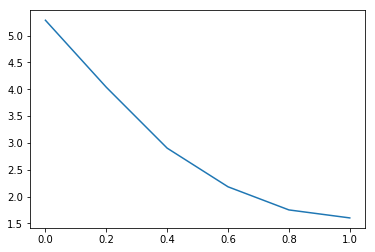

In [77]:
X = np.arange(0, 1.01, step=0.2)
ents = [text_entropy(perturb(text_en, e)) for e in X]
plt.plot(X, ents)
plt.show()

# Conditional entropy

In [78]:
def min_avg_max(items):
    return min(items), np.mean(items).item(), max(items)

In [126]:
def plot_iters(f, title):
    random.seed(1)

    data = []
    p_values = [0.1, 0.05, 0.01, 0.001, 0.0001, 0.00001]

    for p in p_values:
        ents = [f(p) for _ in range(10)]

        data.append(min_avg_max(ents))

    data = np.array(data)
    
    for i, label in enumerate(["min", "avg", "max"]):
        plt.plot(p_values, data[:, i], label=label)

    plt.title(title)
    plt.legend()
    plt.show()
    
    return np.hstack([np.array(p_values).reshape(-1, 1), data])

def perturb_word(words, dictionary, p):
    return [w if (random.random() > p) else random.choice(dictionary) for w in words]

# Messing up words and characters

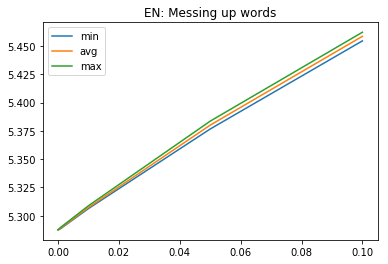

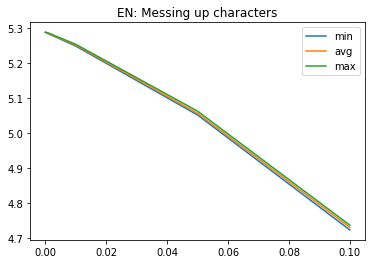

array([[1.00000000e-01, 4.72355135e+00, 4.73089040e+00, 4.73723547e+00],
       [5.00000000e-02, 5.05140620e+00, 5.05621544e+00, 5.06237915e+00],
       [1.00000000e-02, 5.24796337e+00, 5.25072362e+00, 5.25296610e+00],
       [1.00000000e-03, 5.28317423e+00, 5.28405824e+00, 5.28534563e+00],
       [1.00000000e-04, 5.28685534e+00, 5.28713136e+00, 5.28741957e+00],
       [1.00000000e-05, 5.28739653e+00, 5.28743845e+00, 5.28751651e+00]])

In [127]:
en_words = text_en.split("\n")
en_dictionary = list(set(en_words))

plot_iters(lambda p: text_entropy("\n".join(perturb_word(en_words, en_dictionary, p))), "EN: Messing up words")
plot_iters(lambda p: text_entropy(perturb(text_en, p)), "EN: Messing up characters")

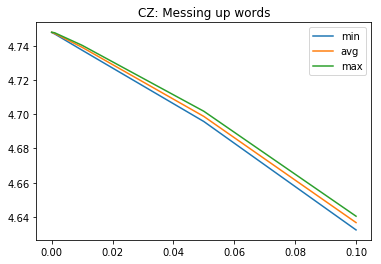

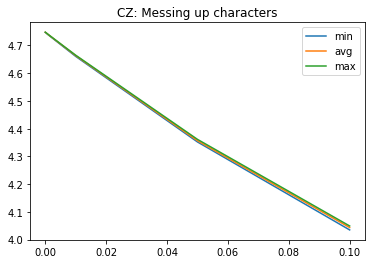

array([[1.00000000e-01, 4.03502257e+00, 4.04356952e+00, 4.04918777e+00],
       [5.00000000e-02, 4.35222944e+00, 4.35667707e+00, 4.36155333e+00],
       [1.00000000e-02, 4.66076252e+00, 4.66341611e+00, 4.66502215e+00],
       [1.00000000e-03, 4.73827625e+00, 4.73910070e+00, 4.73960977e+00],
       [1.00000000e-04, 4.74665906e+00, 4.74695300e+00, 4.74736392e+00],
       [1.00000000e-05, 4.74763926e+00, 4.74771732e+00, 4.74779502e+00]])

In [128]:
cz_words = text_cz.split("\n")
cz_dictionary = list(set(cz_words))

plot_iters(lambda p: text_entropy("\n".join(perturb_word(cz_words, cz_dictionary, p))), "CZ: Messing up words")
plot_iters(lambda p: text_entropy(perturb(text_cz, p)), "CZ: Messing up characters")

# Cross entropy and language modeling

In [129]:
en_words = text_en.split("\n")

In [148]:
en_test_words = en_words[-20000:]
en_heldout_words = en_words[-60000:-20000]
en_train_words = en_words[:-60000]

en_dictionary = list(set(en_train_words))

V = len(en_dictionary)
T = len(en_train_words)

In [149]:
len(en_train_words), len(en_heldout_words), len(en_test_words)

(161099, 40000, 20000)

In [150]:
train_w_stop = en_train_words + ["<STOP>"]
train_w_start_stop = ["<START>"] + train_w_stop

c1 = Counter(en_train_words)
c2 = Counter(zip(train_w_stop, train_w_stop[1:]))
c3 = Counter(zip(train_w_start_stop, train_w_start_stop[1:], train_w_start_stop[2:]))

In [151]:
assert sum(c1.values()) == len(en_train_words)
assert sum(c1.values()) == sum(c2.values())
assert sum(c1.values()) == sum(c3.values())

In [165]:
uniform = 1.0 / V
unigram = {w: float(c)/T for w, c in c1.items()}
bigram = {w: float(c) / c1[w[0]] for w, c in c2.items()}
trigram = {w: float(c) / c2[w[:2]] if c2[w[:2]] > 0 else 0 for w, c in c3.items()}

In [166]:
trigram

{('<START>', 'WHEN', 'on'): 0,
 ('WHEN', 'on', 'board'): 1.0,
 ('on', 'board', 'H'): 1.0,
 ('board', 'H', '.'): 1.0,
 ('H', '.', 'M'): 0.1,
 ('.', 'M', '.'): 1.0,
 ('M', '.', 'S'): 0.058823529411764705,
 ('.', 'S', '.'): 1.0,
 ('S', '.', 'Beagle'): 0.07692307692307693,
 ('.', 'Beagle', 'as'): 1.0,
 ('Beagle', 'as', 'naturalist'): 1.0,
 ('as', 'naturalist', ','): 1.0,
 ('naturalist', ',', 'I'): 0.2222222222222222,
 (',', 'I', 'was'): 0.04430379746835443,
 ('I', 'was', 'much'): 0.23529411764705882,
 ('was', 'much', 'struck'): 0.6666666666666666,
 ('much', 'struck', 'with'): 0.14285714285714285,
 ('struck', 'with', 'certain'): 0.3333333333333333,
 ('with', 'certain', 'facts'): 0.14285714285714285,
 ('certain', 'facts', 'in'): 1.0,
 ('facts', 'in', 'the'): 0.1,
 ('in', 'the', 'distribution'): 0.0030425963488843813,
 ('the', 'distribution', 'of'): 0.875,
 ('distribution', 'of', 'the'): 0.25,
 ('of', 'the', 'organic'): 0.002581311306143521,
 ('the', 'organic', 'beings'): 0.07692307692307693,

In [169]:
sum({k: v for k, v in trigram.items() if k[0] == "M" and k[1] == "."}.values())

1.0

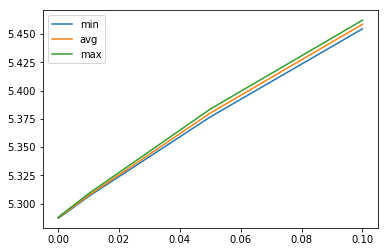

In [87]:
perturb_word(words, dictionary, 1)[:3]

random.seed(1)

data = []
p_values = [0.1, 0.05, 0.01, 0.001, 0.0001, 0.00001]

for p in p_values:
    ents = [text_entropy("\n".join(perturb_word(words, dictionary, p))) for _ in range(10)]
    
    data.append(min_avg_max(ents))
    
data = np.array(data)

for i, label in enumerate(["min", "avg", "max"]):
    plt.plot(p_values, data[:, i], label=label)
    
plt.legend()

In [97]:
np.array(p_values).reshape(-1, 1).shape, data.shape

((6, 1), (6, 3))

In [106]:
print(np.hstack([np.array(p_values).reshape(-1, 1), data]))

[[1.00000000e-01 5.45452976e+00 5.45857768e+00 5.46215701e+00]
 [5.00000000e-02 5.37665453e+00 5.38006277e+00 5.38358588e+00]
 [1.00000000e-02 5.30632348e+00 5.30726992e+00 5.30881384e+00]
 [1.00000000e-03 5.28884974e+00 5.28928991e+00 5.28999699e+00]
 [1.00000000e-04 5.28748221e+00 5.28764168e+00 5.28782518e+00]
 [1.00000000e-05 5.28745349e+00 5.28749044e+00 5.28756782e+00]]


# TODO _More combinations of words, conditioning doesn't help as much_